In [2]:
import numpy as np
import torch
import tntorch as tn
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit.library import UnitaryGate
from time import process_time as cput

%matplotlib inline


#PARAMETRI GAUSSIANA

num_dimensions = 1
mu = 0.10   # Mean vector
cov_matrix = 0.20  # Covariance matrix 

def gaussian(x):
    return 1/(np.sqrt(2*np.pi)*cov_matrix) * np.exp(-0.5*(((x-mu)/cov_matrix)**2))

def contract_tt_cores(cores):
    """
    Contrai sequenzialmente i TT‐cores lungo le dimensioni di rango.
    Input:
      cores: lista di numpy array di shape (r_{k-1}, i_k, r_k)
    Output:
      array numpy del tensore completo di shape (i_1, i_2, ..., i_d)
    """
    # Partiamo dal primo core, shape (r0, i1, r1), tipicamente r0=1
    result = cores[0]

    # Per ogni core successivo, contrae l'ultimo asse di result (r_k)
    # con il primo asse del nuovo core (stesso r_k)
    for C in cores[1:]:
        # axes=([-1], [0]) = ultimo asse di result con primo asse di C
        result = np.tensordot(result, C, axes=([-1], [0]))
        # dopo la tensordot, le modalità si dispongono in questo ordine:
        # (..., i_k, r_k) ⨂ (r_k, i_{k+1}, r_{k+1})
        # → (..., i_k, i_{k+1}, r_{k+1})
    
    # Alla fine r_d = 1, quindi eliminiamo le dim singleton
    return np.squeeze(result)

def tensor_train(n_qubits, bond_dimension,domain_np):
    m = 2**n_qubits              # dimensioni discretizzazione
    vec =  np.array([gaussian(x) for x in domain_np])    # vettore probabilità discreta

    shape = (2,)*n_qubits        # (2,2,2,2)
    A = vec.reshape(shape) #tensore numpy
    T = tn.Tensor(A)      #tensore torch


    #CREAZIONE TENSOR TRAIN

    TTrain = tn.cross(
    function=lambda x: x,   # identità su ciascuna fibra
    tensors=[T],            # lista di un solo tensore               
    ranks_tt=bond_dimension,                 # rank massimo ammesso
    verbose=False,
    )   
    toc = cput()
    cores_torch = TTrain.cores
    cores = [c.cpu().numpy() for c in cores_torch]
    return contract_tt_cores(cores)

In [3]:
def solomov(tensor,n,domain_np,vec):

    values = np.reshape(tensor,shape=2**n)
    probs = np.abs(values[:])  
    dx = domain_np[1] - domain_np[0]

    I = np.trapezoid(probs, x = domain_np, dx = dx)
    probs = probs / I
    F = np.zeros(len(domain_np))
    G = np.zeros(len(domain_np))
    N_loc = len(domain_np)

    for y in range(N_loc):
        F[y] = np.trapezoid(vec[:y],x = domain_np[:y], dx = dx)
        G[y] = np.trapezoid(probs[:y],x = domain_np[:y], dx = dx)

    #plt.plot(domain_np,F,label='True function')
    #plt.plot(domain_np,G,label='TT function')
    #plt.title('Kolmogorov-Simrnov for n=1 and 10 qubits')
    #plt.legend()    

    D = np.max(np.abs(F-G))

    return D

In [4]:
nqubits = np.arange(2, 15, dtype=int)
bond = [2,4,8,16]
time = np.zeros((len(nqubits),len(bond)))
D = np.zeros((len(nqubits),len(bond)))

for n_index, n in enumerate(nqubits):
    for b_index, b in enumerate(bond):

        N = 2 ** n
        domain_np = np.linspace(mu - 3*np.sqrt(cov_matrix), mu + 3*np.sqrt(cov_matrix), N)
        vec =  np.array([gaussian(x) for x in domain_np])

        tic = cput()
        tensor = tensor_train(n_qubits=n,bond_dimension=b,domain_np=domain_np) 
        toc = cput()
        D[n_index,b_index] = solomov(tensor=tensor,n = n,domain_np = domain_np, vec=vec)

        time[n_index,b_index] = toc - tic

    print('Finito il calcolo per n = ',n)

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  2
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  7
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  9
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by

Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  10
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  11
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  12
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  13


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.


Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Finito il calcolo per n =  14


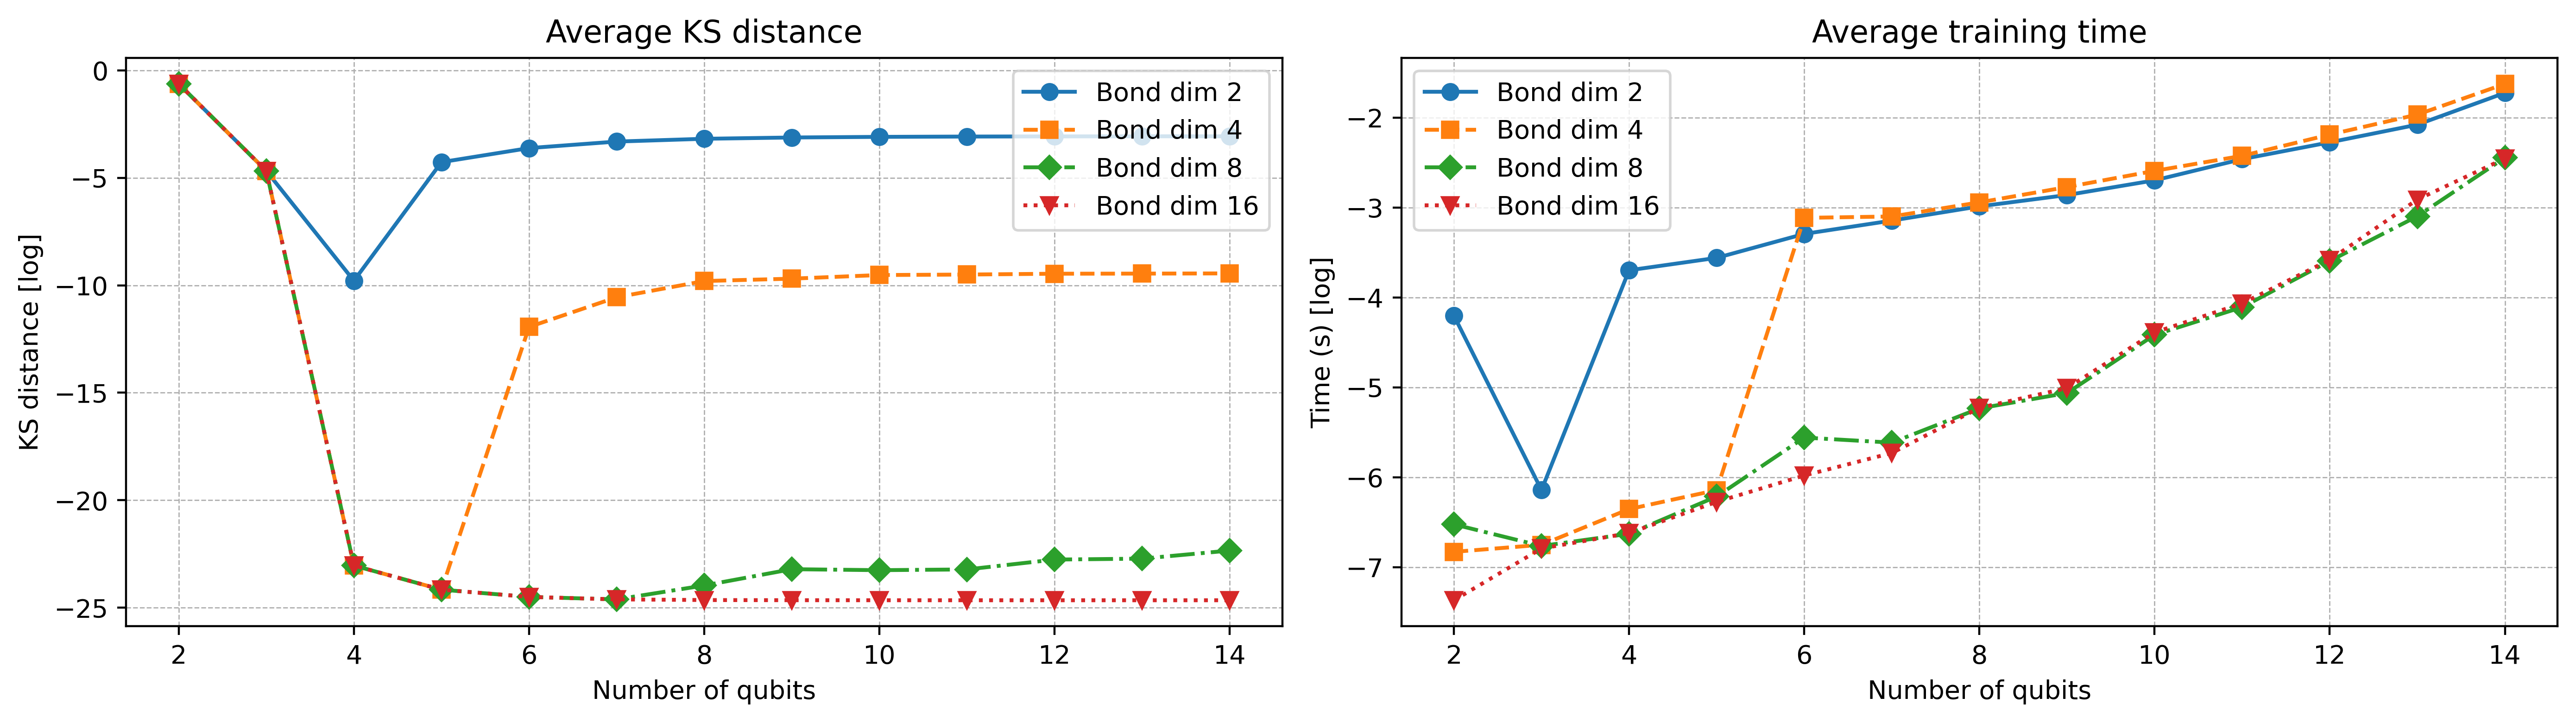

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4),dpi=400)

# Left: KS distance with error bars
for d, style in enumerate(['o-', 's--', 'D-.', 'v:']):
    ax1.plot(nqubits, np.log(D[:,d]), style, label=f'Bond dim {bond[d]}')
#ax1.set_yscale('log')
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel('KS distance [log]')
ax1.set_title('Average KS distance')
ax1.grid(which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Right: Training time
for d, style in enumerate(['o-', 's--', 'D-.', 'v:']):
    ax2.plot(nqubits, np.log(time[:,d]), style, label=f'Bond dim {bond[d]}')
#ax2.set_yscale('log')
ax2.set_xlabel('Number of qubits')
ax2.set_ylabel('Time (s) [log]')
ax2.set_title('Average training time')
ax2.grid(which='both', linestyle='--', linewidth=0.5)
ax2.legend()

plt.tight_layout()
plt.savefig('kolomog.png')
plt.show()